In [1]:
import pypesto
import pypesto.petab
import pypesto.sample as sample
import pypesto.visualize as visualize
import pandas as pd

import petab
import numpy as np
import pickle
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

datatype = "loss"

# import data
if datatype == "original":
    dataframe = pd.read_csv("corrupted_data/SS_measurements_original.tsv", sep = "\t")
elif datatype == "switch":
    dataframe = pd.read_csv("corrupted_data/SS_measurements_switch.tsv", sep = "\t")
else:
    dataframe = pd.read_csv("corrupted_data/SS_measurements_loss.tsv", sep = "\t")

# experimental data
data = np.array(dataframe.measurement)
# time vector
tvec = np.array(dataframe.time)
N = len(tvec)

In [2]:
def analytical_b(t, a0, b0, k1, k2):
    return (k2 - k2 * np.exp(-(k2 + k1) * t)) / (k2 + k1)

def simulate_model(x, tvec):
    # assign parameters
    k2, _, _ = x
    k1 = np.exp(-1.2741)
    # define initial conditions
    a0 = 1
    b0 = 0
    # simulate model
    simulation = [analytical_b(t, a0, b0, k1, k2)
                   for t in tvec]
    return simulation

After importing the model, we need to define the objective function. This time we will do it via an external function that will be used then by pyPESTO instead of using the built-in ones.

For numerical reasons we will implement the log likelihood and log prior.

In [3]:
def log_prior(x):
    """ Log prior function."""
    # assign variables from input x
    scale = x[-1]


    # the prior
    exp_prior = np.log(lamda) - lamda * scale
    
    return exp_prior


def negative_log_posterior(x):
    """ Negative log posterior function."""

    shape = x[-2]
    scale = x[-1]

    # simulate model
    _simulation = simulate_model(np.exp(x), tvec)
    simulation = (scale * np.asarray(_simulation))

    # evaluate standard log likelihood
    aux1 = np.absolute(data - simulation)
    aux2 = np.sum(aux1) / shape

    l_llh = -(N*(np.log(2) + np.log(shape)) + aux2)

    # evaluate log normal-gamma prior
    l_prior = log_prior(x)

    # return NEGATIVE log posterior (required for pyPESTO)
    return -(l_llh + l_prior)

Now that we have the objective function defined, we need to create a pyPESTO problem.

In [4]:
def standard_sampling():
    """Creates a pyPESTO problem."""
    objective = pypesto.Objective(fun=negative_log_posterior)
    problem = pypesto.Problem(objective=objective,  # objective function
                              lb=[-10, 0, 0],  # lower bounds
                              ub=[10, np.inf, np.inf],  # upper bounds
                              x_names=['k2', 'shape','scaling'],  # parameter names
                              x_scales=['log', 'lin', 'lin'])  # parameter scale
    return problem

In [5]:
### Prior dependent paramters

lamda = 0.01

# create the estimation problem
problem = standard_sampling()

# MCMC chain length
n_samples= 1e5

x0 = np.array([-5, 0.3684, 1.011])

# call the sampler of choice
sampler = sample.AdaptiveMetropolisSampler()

In [6]:
# Define number of runs
runs = 1

save_results = False # for testing just set to False

# Loop over n runs
for n in range(runs):
    # set initial random seed
    np.random.seed(n)
    # perform MCMC sampling
    result = sample.sample(problem, n_samples=n_samples, sampler=sampler,
                           x0=x0)
    # calculate effective sample size
    sample.effective_sample_size(result=result)

    # save the results as a pickle object
    if save_results:
        results = result.sample_result
        with open('Results/Full_parameter/' + str(n) + '.pickle','wb') as result_file:
            pickle.dump(results, result_file, n)

100%|██████████| 100000/100000 [00:36<00:00, 2736.19it/s]
Elapsed time: 33.942496
Geweke burn-in index: 5000
Estimated chain autocorrelation: 86.2150919474654
Estimated effective sample size: 1089.272485743918


There are some built-in visualization functions that one can use.

1089.272485743918
32.091702559055115


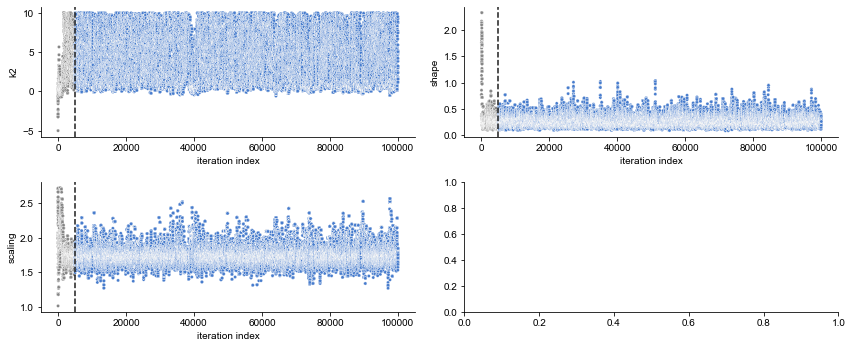

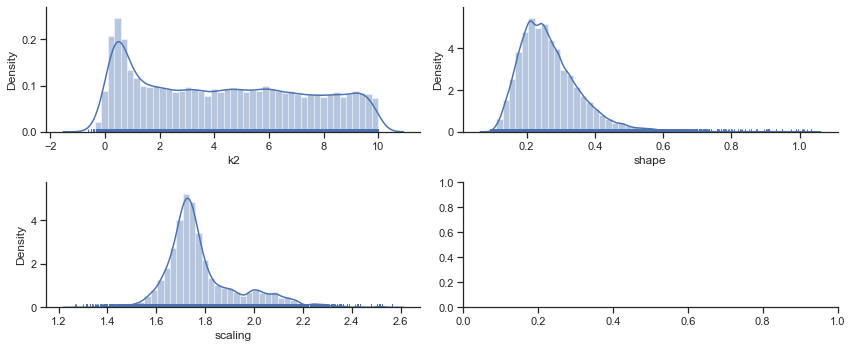

In [7]:
print(result.sample_result.effective_sample_size)
print(result.sample_result.effective_sample_size/result.sample_result.time)
# Visualize the parameter trace

result.sample_result.burn_in = 5000

ax = visualize.sampling.sampling_parameters_trace(result, use_problem_bounds=False, full_trace=True, size=(12,5))
# Visualize the one-dimensional marginals --> Important!
ax = visualize.sampling_1d_marginals(result, size=(12,5))
#ax = visualize.sampling_fval_traces(result, size=(12,5))

[0.43074513 0.18975821 2.04181587]


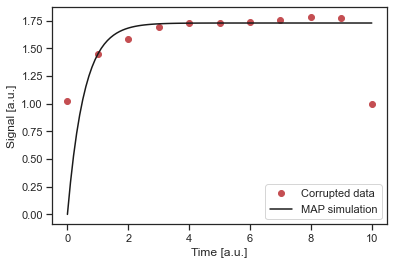

In [8]:
def Simulation_data_comparison():
    MAP_index=np.argmax(-result.sample_result.trace_neglogpost[0,result.sample_result.burn_in:])
    MAP = result.sample_result.trace_x[0,result.sample_result.burn_in+MAP_index,:]
    print(MAP)
    
    # experimental data
    data = np.array(dataframe.measurement)
    # time vector
    tvec = np.array(dataframe.time)

    tvec_for_simulation = np.linspace(tvec[0],tvec[-1],100)

    scale = MAP[-1]

    # simulate model
    _simulation = simulate_model(np.exp(MAP), tvec_for_simulation)
    simulation = (scale * np.asarray(_simulation))
    
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(tvec,data,'or',label='Corrupted data')
    plt.plot(tvec_for_simulation,simulation,'k',label='MAP simulation')
    plt.xlabel('Time [a.u.]')
    plt.ylabel('Signal [a.u.]')
    #plt.ylim([0,2])
    plt.legend()
    plt.show()
    
Simulation_data_comparison()